### Gesture2Emote - LOSOCV Version

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling1D, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling1D, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
def load_and_organize_data(npy_dir):
    data = {}
    subject_ids = set()
    rec_types = set()
    gesture_classes = set()
    trials = set()
    body_segments = set()

    for filename in os.listdir(npy_dir):
        if filename.endswith('.npy'):
            parts = filename.split('_')
            subject_id = parts[0][3:]
            rec_type = parts[1]
            gesture_class = parts[2] if rec_type != 'Idle' else 'Idle'
            trial_number = parts[3].split('-')[-1] if rec_type != 'Idle' else parts[2].split('-')[-1]
            segment = parts[-1].replace('.npy', '')

            subject_ids.add(subject_id)
            rec_types.add(rec_type)
            gesture_classes.add(gesture_class)
            trials.add(trial_number)
            body_segments.add(segment)

            # Load
            filepath = os.path.join(npy_dir, filename)
            imu_data = np.load(filepath)

            # Save in an organized manner
            if subject_id not in data:
                data[subject_id] = {
                    'Segmented': {},
                    'Continuous': {},
                    'Idle': {},
                }
            if rec_type == 'Segmented' or rec_type == 'Continuous':
                if gesture_class not in data[subject_id][rec_type]:
                    data[subject_id][rec_type][gesture_class] = {}
                if trial_number not in data[subject_id][rec_type][gesture_class]:
                    data[subject_id][rec_type][gesture_class][trial_number] = {}
                data[subject_id][rec_type][gesture_class][trial_number][segment] = imu_data

            elif rec_type == 'Idle':
                if 'Idle' not in data[subject_id][rec_type]:
                    data[subject_id][rec_type]['Idle'] = {}
                if trial_number not in data[subject_id][rec_type]['Idle']:
                    data[subject_id][rec_type]['Idle'][trial_number] = {}
                data[subject_id][rec_type]['Idle'][trial_number][segment] = imu_data

    print("Data loading complete.")
    print(f"{len(subject_ids)} Subject IDs: {sorted(subject_ids)}")
    print(f"{len(rec_types)} Recording Types: {sorted(rec_types)}")
    print(f"{len(gesture_classes)} Gesture Classes: {sorted(gesture_classes)}")
    print(f"{len(trials)} Trials: {min(trials)} to {max(trials)}")
    print(f"{len(body_segments)} Body Segments: {sorted(body_segments)}")
    return data


In [3]:
npy_dir = '/content/drive/My Drive/Numpy_Data/'
data = load_and_organize_data(npy_dir)

Data loading complete.
5 Subject IDs: ['001', '002', '003', '004', '005']
3 Recording Types: ['Continuous', 'Idle', 'Segmented']
11 Gesture Classes: ['Angry', 'Cheer', 'Clap', 'Come', 'Crazy', 'Facepalm', 'Idle', 'Point', 'Salute', 'ThumbsUp', 'Wave']
50 Trials: 000 to 049
3 Body Segments: ['HAND', 'fARM', 'uARM']


In [4]:
def prepare_data_for_LOSO(data, subject_id_to_exclude):
    X_train, y_train, X_test, y_test = [], [], [], []

    for subject_id, rec_types in data.items():
        for rec_type, gestures in rec_types.items():
            for gesture_class, trials in gestures.items():
                for trial_number, segments in trials.items():
                    if 'HAND' in segments and 'fARM' in segments and 'uARM' in segments:
                        # to avoid packet loss
                        max_length = max(len(segments['HAND']), len(segments['fARM']), len(segments['uARM']))

                        hand_data = np.pad(segments['HAND'], ((0, max_length - len(segments['HAND'])), (0, 0)), mode='constant')
                        farm_data = np.pad(segments['fARM'], ((0, max_length - len(segments['fARM'])), (0, 0)), mode='constant')
                        uarm_data = np.pad(segments['uARM'], ((0, max_length - len(segments['uARM'])), (0, 0)), mode='constant')

                        imu_data = np.concatenate([hand_data, farm_data, uarm_data], axis=1)  # Resulting shape should be (max_length, 21)

                        # ensure at least 1 window fit
                        if len(imu_data) < window_size:
                            imu_data = np.pad(imu_data, ((0, window_size - len(imu_data)), (0, 0)), mode='constant')


                        # Normalize features
                        scaler = StandardScaler()
                        imu_data_scaled = scaler.fit_transform(imu_data)

                        # Apply sliding window
                        for start in range(0, len(imu_data_scaled) - window_size + 1, step_size):
                            end = start + window_size
                            window = imu_data_scaled[start:end]

                            # LOSO
                            if subject_id == subject_id_to_exclude:
                                X_test.append(window)
                                y_test.append(gesture_class)
                            else:
                                X_train.append(window)
                                y_train.append(gesture_class)

    # Convert lists to arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    # One-hot encode labels
    labels = list(sorted(set(y_train + y_test)))
    y_train_encoded = np.array([labels.index(label) for label in y_train])
    y_test_encoded = np.array([labels.index(label) for label in y_test])
    y_train_one_hot = to_categorical(y_train_encoded, num_classes=len(labels))
    y_test_one_hot = to_categorical(y_test_encoded, num_classes=len(labels))

    return X_train, y_train_one_hot, X_test, y_test_one_hot, labels


In [5]:
# I'll use only the best performing model from the non LOSOCV version...
def model_cnn_3(input_shape, num_classes):
    model = Sequential([
        # First Block
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Second Block
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Third Block
        Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Fourth Block
        Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        
        # Flatten and Fully Connected Layer
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [6]:
def loso_cross_validation(data, model_cnn, num_subjects, save_dir='best_model', initial_batch_size=32, epochs_per_step=30, steps=3):
    all_test_accuracies = []
    
    subject_ids = list(data.keys())
    
    for subject_id in subject_ids:
        print(f"\nLeave-One-Subject-Out Cross-Validation for Subject {subject_id}")

        # Prepare data
        X_train, y_train, X_test, y_test, labels = prepare_data_for_LOSO(data, subject_id)
        
        # Train and evaluate model
        test_accuracy = train_and_evaluate_cnn(X_train, y_train, X_test, y_test, model_cnn, labels, save_dir, initial_batch_size, epochs_per_step, steps)
        all_test_accuracies.append(test_accuracy)
        
        print(f"Test Accuracy for Subject {subject_id}: {test_accuracy:.4f}")
    
    print(f"\nAverage Test Accuracy across all subjects: {np.mean(all_test_accuracies):.4f}")
    return all_test_accuracies

In [7]:
def train_and_evaluate_cnn(X_train, y_train, X_test, y_test, model_cnn, labels, save_dir='best_model', initial_batch_size=32, epochs_per_step=30, steps=3):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, 'cnnlosocv_best_model.keras')

    # Callbacks
    save_model = ModelCheckpoint(
        model_path, 
        save_best_only=True, 
        monitor='val_loss', 
        mode='min', 
        verbose=0
    )
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10
    )
    reducelr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8, 
        patience=3, 
        verbose=0, 
        mode='min', 
        min_lr=1e-5
    )

    # Build the CNN model
    input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
    num_classes = y_train.shape[1]
    cnn_model = model_cnn(input_shape, num_classes)

    # Training with varying batch sizes
    full_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    batch_size = initial_batch_size
    for step in range(steps):
        print(f"\nTraining with batch size: {batch_size}")

        history = cnn_model.fit(
            X_train, y_train, 
            validation_data=(X_test, y_test), 
            epochs=epochs_per_step, 
            batch_size=batch_size, 
            callbacks=[save_model, early_stopping, reducelr],
            verbose=0
        )

        # Append current history to full_history for train/val accuracy plot
        for key in full_history.keys():
            full_history[key].extend(history.history[key])

        batch_size *= 2

    # Load the best model and evaluate
    cnn_model.load_weights(model_path)
    test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predict the classes
    y_pred = cnn_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_cnn.__name__} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(full_history['loss'], label='Train Loss')
    plt.plot(full_history['val_loss'], label='Val Loss')
    plt.title(f'{model_cnn.__name__} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(full_history['accuracy'], label='Train Accuracy')
    plt.plot(full_history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_cnn.__name__} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Calculate F1 Score, Precision, and Recall
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    report = classification_report(y_true, y_pred_classes, target_names=labels)
    
    print(f"F1 Score (Weighted): {f1:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print("Classification Report:\n", report)

    return test_accuracy


Leave-One-Subject-Out Cross-Validation for Subject 001

Training with batch size: 32

Training with batch size: 64

Training with batch size: 128
Test Accuracy: 0.7330
32/32 [==============================] - 0s 2ms/step


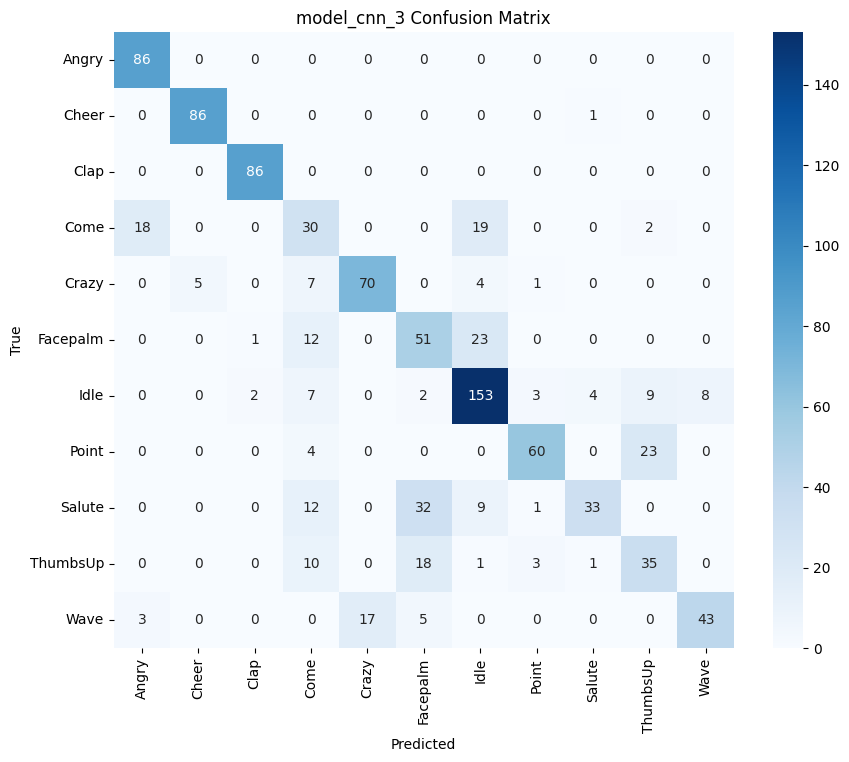

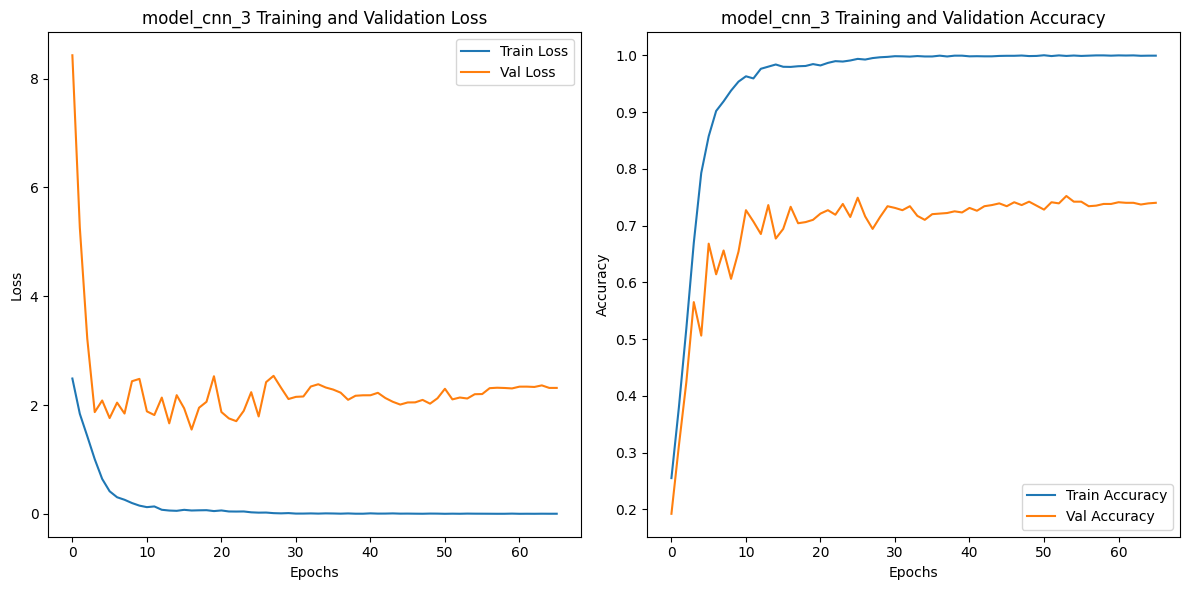

F1 Score (Weighted): 0.7299
Precision (Weighted): 0.7506
Recall (Weighted): 0.7330
Classification Report:
               precision    recall  f1-score   support

       Angry       0.80      1.00      0.89        86
       Cheer       0.95      0.99      0.97        87
        Clap       0.97      1.00      0.98        86
        Come       0.37      0.43      0.40        69
       Crazy       0.80      0.80      0.80        87
    Facepalm       0.47      0.59      0.52        87
        Idle       0.73      0.81      0.77       188
       Point       0.88      0.69      0.77        87
      Salute       0.85      0.38      0.52        87
    ThumbsUp       0.51      0.51      0.51        68
        Wave       0.84      0.63      0.72        68

    accuracy                           0.73      1000
   macro avg       0.74      0.71      0.72      1000
weighted avg       0.75      0.73      0.73      1000

Test Accuracy for Subject 001: 0.7330

Leave-One-Subject-Out Cross-Validation fo

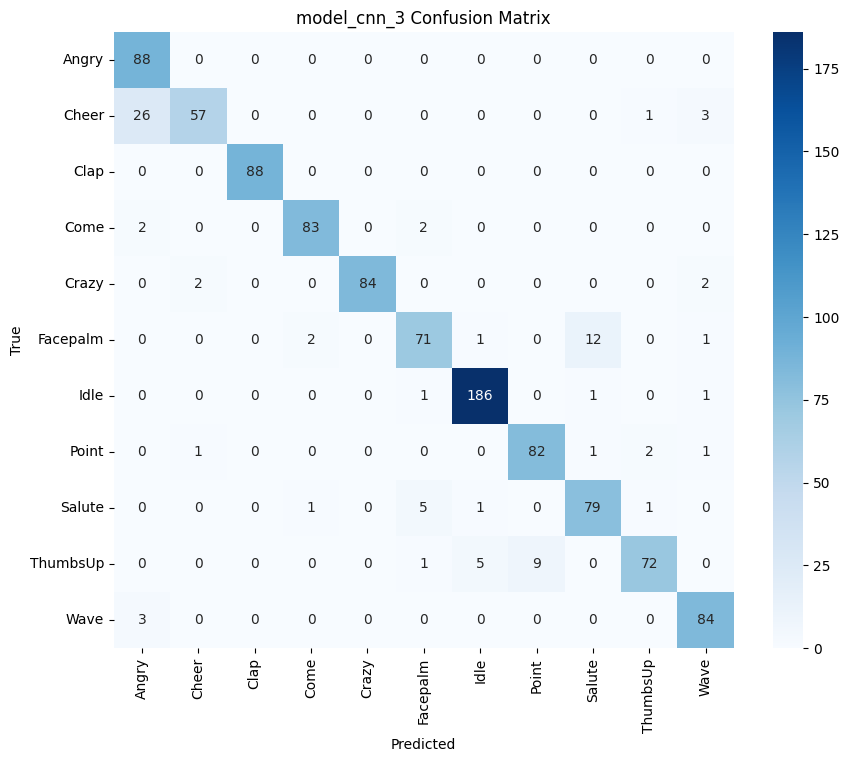

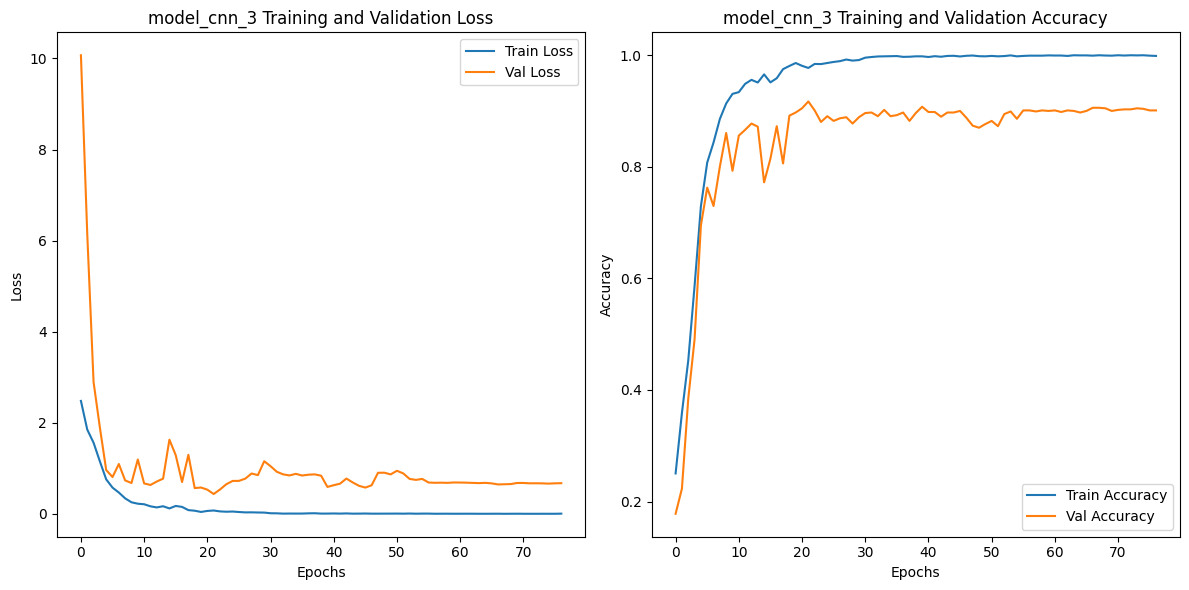

F1 Score (Weighted): 0.9160
Precision (Weighted): 0.9239
Recall (Weighted): 0.9171
Classification Report:
               precision    recall  f1-score   support

       Angry       0.74      1.00      0.85        88
       Cheer       0.95      0.66      0.78        87
        Clap       1.00      1.00      1.00        88
        Come       0.97      0.95      0.96        87
       Crazy       1.00      0.95      0.98        88
    Facepalm       0.89      0.82      0.85        87
        Idle       0.96      0.98      0.97       189
       Point       0.90      0.94      0.92        87
      Salute       0.85      0.91      0.88        87
    ThumbsUp       0.95      0.83      0.88        87
        Wave       0.91      0.97      0.94        87

    accuracy                           0.92      1062
   macro avg       0.92      0.91      0.91      1062
weighted avg       0.92      0.92      0.92      1062

Test Accuracy for Subject 002: 0.9171

Leave-One-Subject-Out Cross-Validation fo

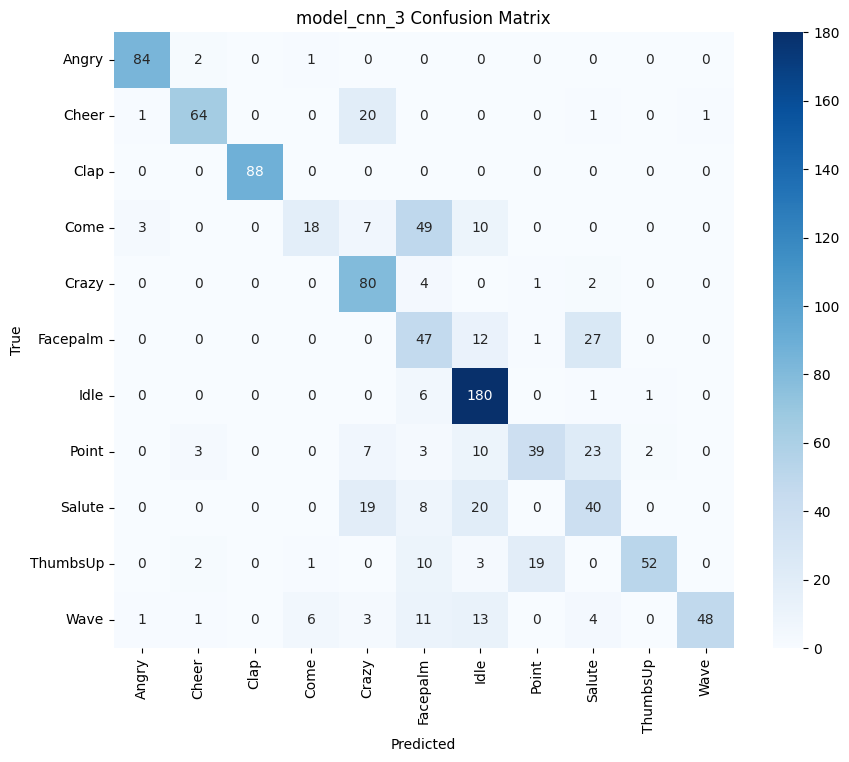

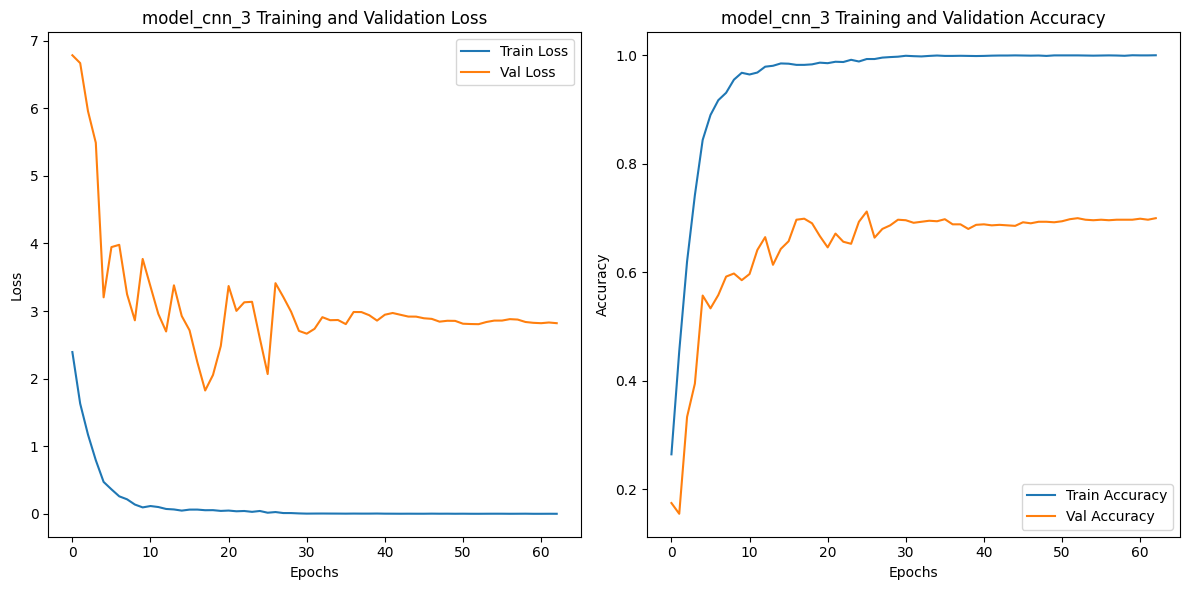

F1 Score (Weighted): 0.6909
Precision (Weighted): 0.7408
Recall (Weighted): 0.6988
Classification Report:
               precision    recall  f1-score   support

       Angry       0.94      0.97      0.95        87
       Cheer       0.89      0.74      0.81        87
        Clap       1.00      1.00      1.00        88
        Come       0.69      0.21      0.32        87
       Crazy       0.59      0.92      0.72        87
    Facepalm       0.34      0.54      0.42        87
        Idle       0.73      0.96      0.83       188
       Point       0.65      0.45      0.53        87
      Salute       0.41      0.46      0.43        87
    ThumbsUp       0.95      0.60      0.73        87
        Wave       0.98      0.55      0.71        87

    accuracy                           0.70      1059
   macro avg       0.74      0.67      0.68      1059
weighted avg       0.74      0.70      0.69      1059

Test Accuracy for Subject 003: 0.6988

Leave-One-Subject-Out Cross-Validation fo

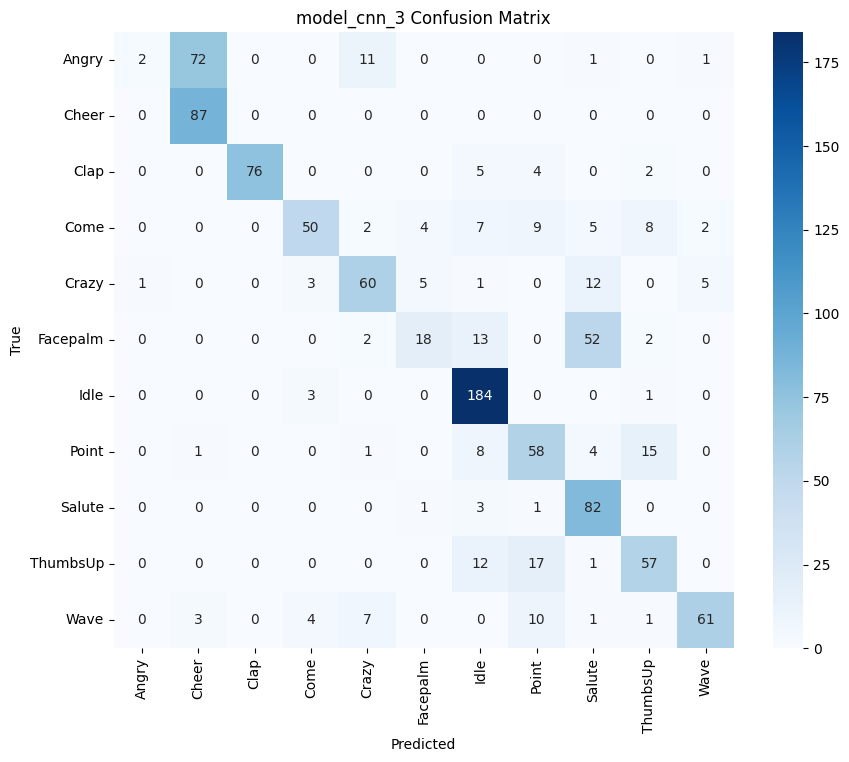

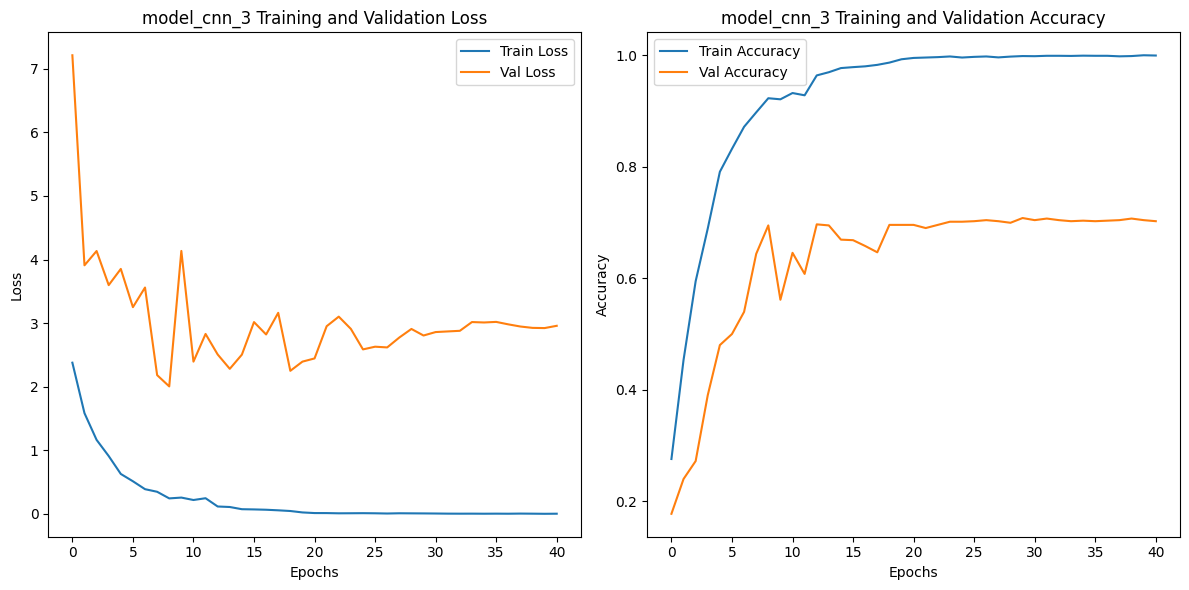

F1 Score (Weighted): 0.6574
Precision (Weighted): 0.7201
Recall (Weighted): 0.6947
Classification Report:
               precision    recall  f1-score   support

       Angry       0.67      0.02      0.04        87
       Cheer       0.53      1.00      0.70        87
        Clap       1.00      0.87      0.93        87
        Come       0.83      0.57      0.68        87
       Crazy       0.72      0.69      0.71        87
    Facepalm       0.64      0.21      0.31        87
        Idle       0.79      0.98      0.87       188
       Point       0.59      0.67      0.62        87
      Salute       0.52      0.94      0.67        87
    ThumbsUp       0.66      0.66      0.66        87
        Wave       0.88      0.70      0.78        87

    accuracy                           0.69      1058
   macro avg       0.71      0.66      0.63      1058
weighted avg       0.72      0.69      0.66      1058

Test Accuracy for Subject 004: 0.6947

Leave-One-Subject-Out Cross-Validation fo

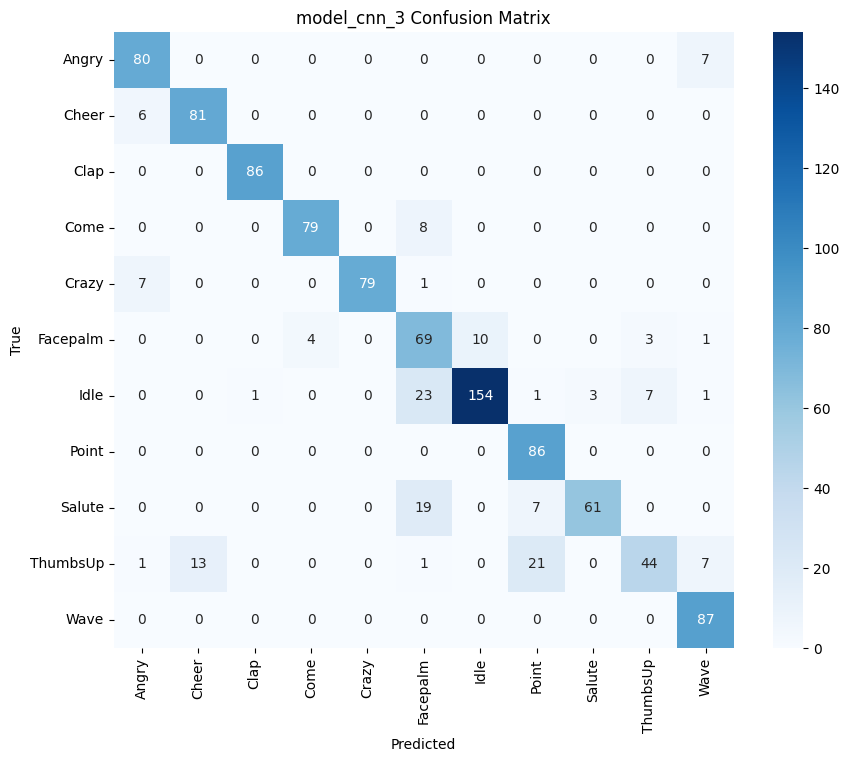

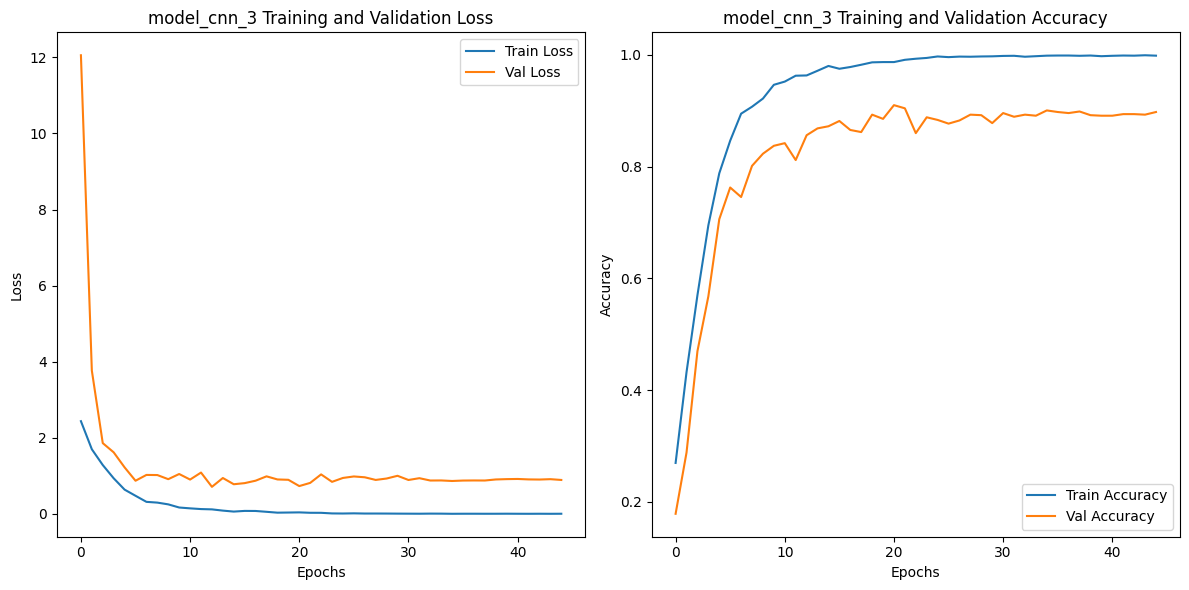

F1 Score (Weighted): 0.8552
Precision (Weighted): 0.8728
Recall (Weighted): 0.8563
Classification Report:
               precision    recall  f1-score   support

       Angry       0.85      0.92      0.88        87
       Cheer       0.86      0.93      0.90        87
        Clap       0.99      1.00      0.99        86
        Come       0.95      0.91      0.93        87
       Crazy       1.00      0.91      0.95        87
    Facepalm       0.57      0.79      0.66        87
        Idle       0.94      0.81      0.87       190
       Point       0.75      1.00      0.86        86
      Salute       0.95      0.70      0.81        87
    ThumbsUp       0.81      0.51      0.62        87
        Wave       0.84      1.00      0.92        87

    accuracy                           0.86      1058
   macro avg       0.87      0.86      0.85      1058
weighted avg       0.87      0.86      0.86      1058

Test Accuracy for Subject 005: 0.8563

Average Test Accuracy across all subjects

[0.7329999804496765,
 0.9171375036239624,
 0.6987724304199219,
 0.6947069764137268,
 0.8563327193260193]

In [8]:

window_size = 380
step_size = 190

num_subjects = len(data)
loso_cross_validation(data, model_cnn_3, num_subjects, save_dir='best_model')

### LOSOCV on the Hybrid model

In [9]:
def train_and_evaluate_lstm(X_train, y_train, X_test, y_test, lstm_model, labels, save_dir='best_model'):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, 'lstm_loso_cv_best_model.keras')

    # Callbacks
    save_model = ModelCheckpoint(
        model_path, 
        save_best_only=True, 
        monitor='val_loss', 
        mode='min', 
        verbose=0
    )
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10
    )
    reducelr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8, 
        patience=3, 
        verbose=0, 
        mode='min', 
        min_lr=1e-5
    )

    # Build the LSTM model
    input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
    num_classes = y_train.shape[1]
    model = lstm_model(input_shape, num_classes)

    # Training with varying batch sizes
    full_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    #history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, 
                            callbacks=[save_model, early_stopping, reducelr], verbose=0)

    # Append current history to full_history for train/val accuracy plot
    for key in full_history.keys():
        full_history[key].extend(history.history[key])

    # Load the best model and evaluate
    model.load_weights(model_path)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predict the classes
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{lstm_model.__name__} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(full_history['loss'], label='Train Loss')
    plt.plot(full_history['val_loss'], label='Val Loss')
    plt.title(f'{lstm_model.__name__} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(full_history['accuracy'], label='Train Accuracy')
    plt.plot(full_history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{lstm_model.__name__} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Calculate F1 Score, Precision, and Recall
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    report = classification_report(y_true, y_pred_classes, target_names=labels)
    
    print(f"F1 Score (Weighted): {f1:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print("Classification Report:\n", report)

    return test_accuracy


In [10]:
window_size = 380
step_size = 190

def hybrid_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Convolutional Layer
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    
    # Bidirectional LSTM Layer
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    
    # Bidirectional LSTM Layer
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    
    # Attention Mechanism
    attention = Attention()([x, x])
    x = Concatenate()([x, attention])
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # Dense Layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model



Running LOSO-CV with subject 001 as the test set
Test Accuracy: 0.5920
32/32 [==============================] - 1s 24ms/step


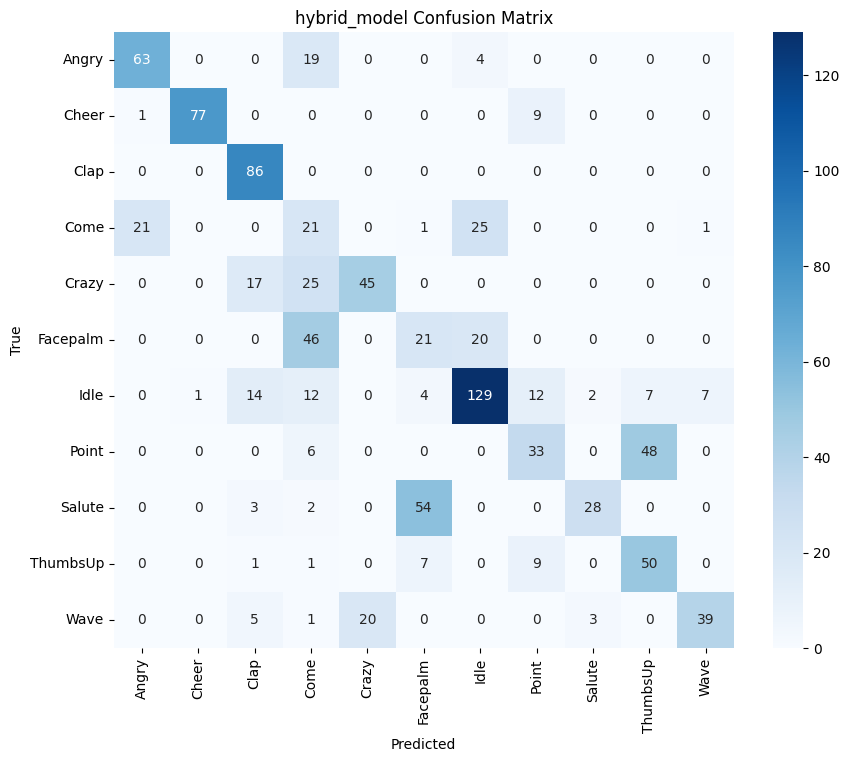

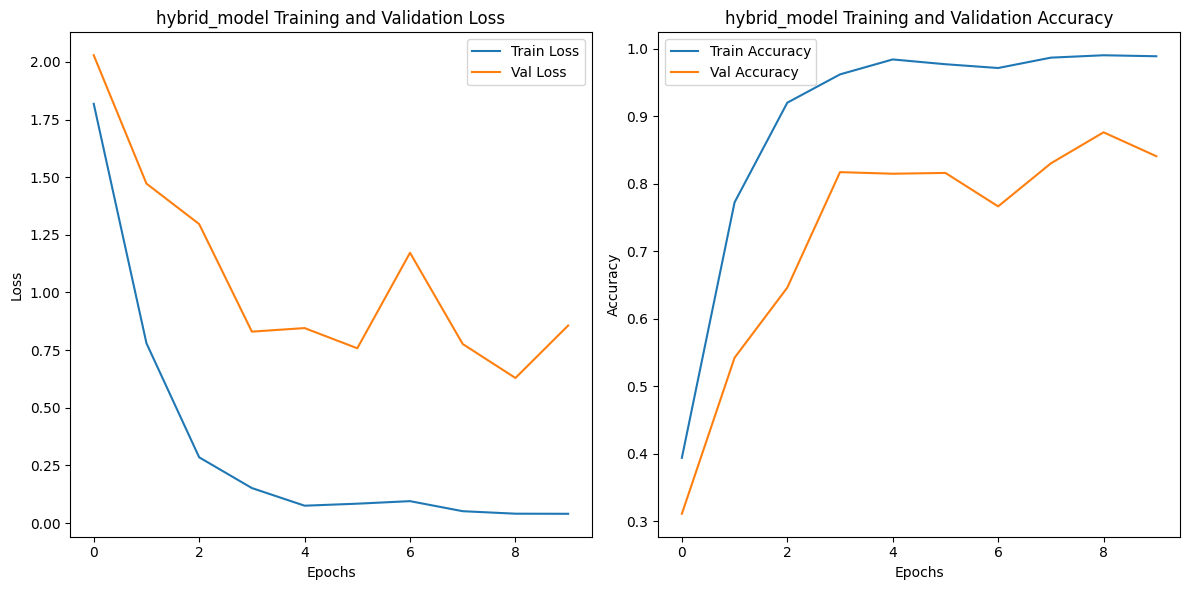

F1 Score (Weighted): 0.5980
Precision (Weighted): 0.6449
Recall (Weighted): 0.5920
Classification Report:
               precision    recall  f1-score   support

       Angry       0.74      0.73      0.74        86
       Cheer       0.99      0.89      0.93        87
        Clap       0.68      1.00      0.81        86
        Come       0.16      0.30      0.21        69
       Crazy       0.69      0.52      0.59        87
    Facepalm       0.24      0.24      0.24        87
        Idle       0.72      0.69      0.70       188
       Point       0.52      0.38      0.44        87
      Salute       0.85      0.32      0.47        87
    ThumbsUp       0.48      0.74      0.58        68
        Wave       0.83      0.57      0.68        68

    accuracy                           0.59      1000
   macro avg       0.63      0.58      0.58      1000
weighted avg       0.64      0.59      0.60      1000

Test Accuracy for subject 001: 0.5920
Running LOSO-CV with subject 002 as the te

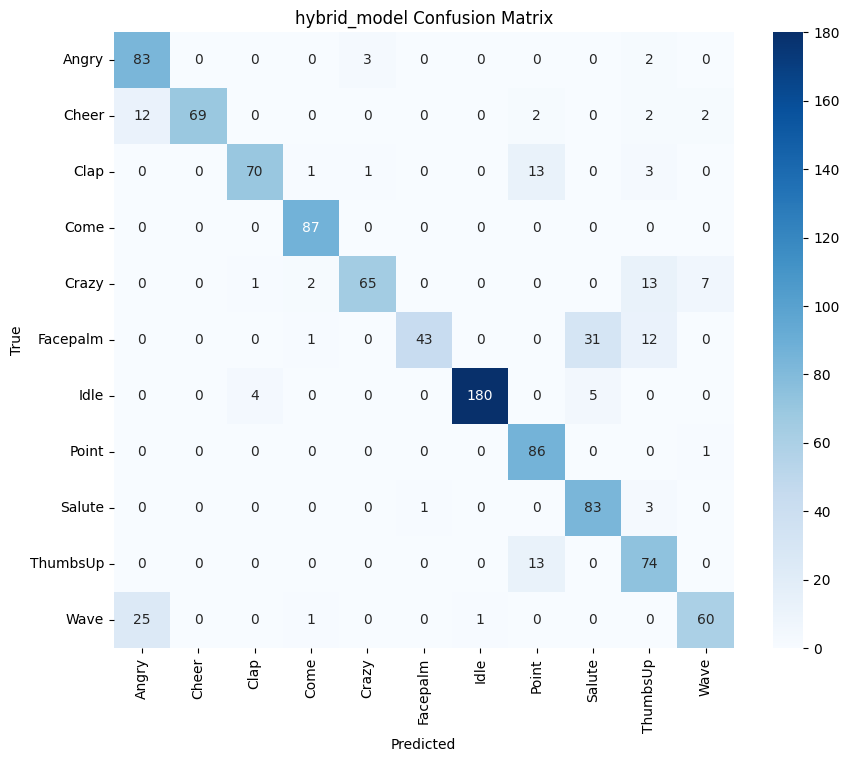

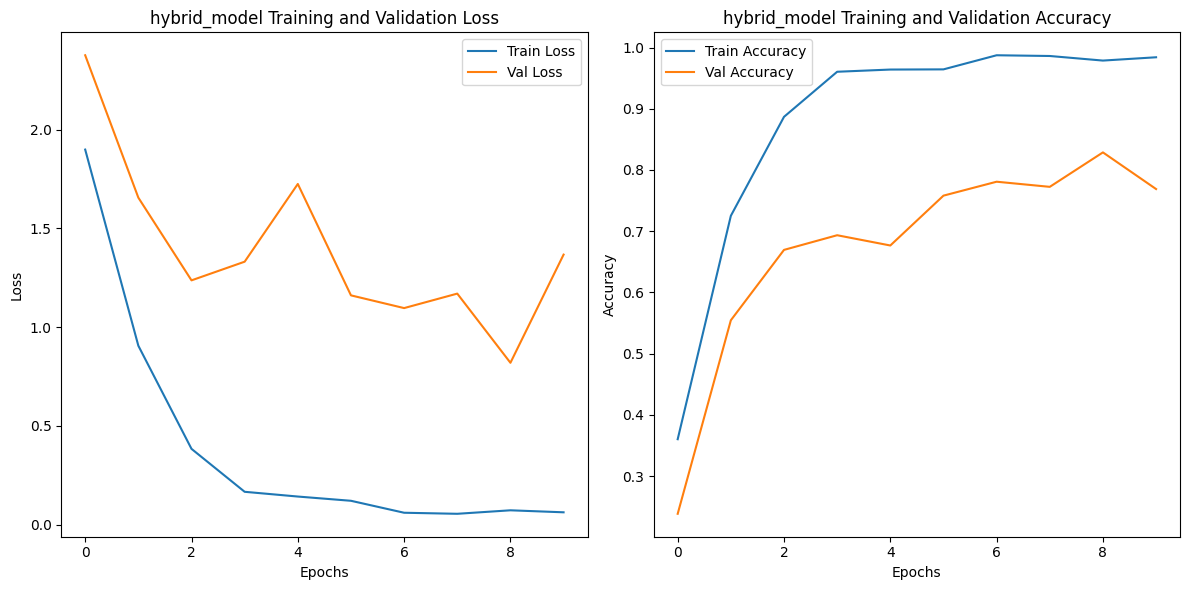

F1 Score (Weighted): 0.8455
Precision (Weighted): 0.8739
Recall (Weighted): 0.8475
Classification Report:
               precision    recall  f1-score   support

       Angry       0.69      0.94      0.80        88
       Cheer       1.00      0.79      0.88        87
        Clap       0.93      0.80      0.86        88
        Come       0.95      1.00      0.97        87
       Crazy       0.94      0.74      0.83        88
    Facepalm       0.98      0.49      0.66        87
        Idle       0.99      0.95      0.97       189
       Point       0.75      0.99      0.86        87
      Salute       0.70      0.95      0.81        87
    ThumbsUp       0.68      0.85      0.76        87
        Wave       0.86      0.69      0.76        87

    accuracy                           0.85      1062
   macro avg       0.86      0.84      0.83      1062
weighted avg       0.87      0.85      0.85      1062

Test Accuracy for subject 002: 0.8475
Running LOSO-CV with subject 003 as the te

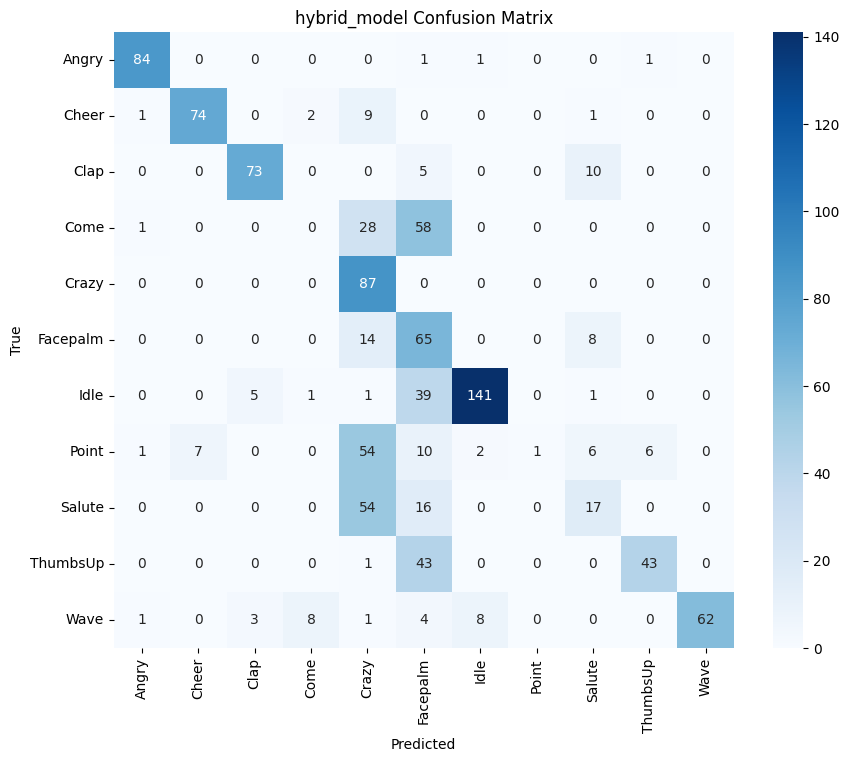

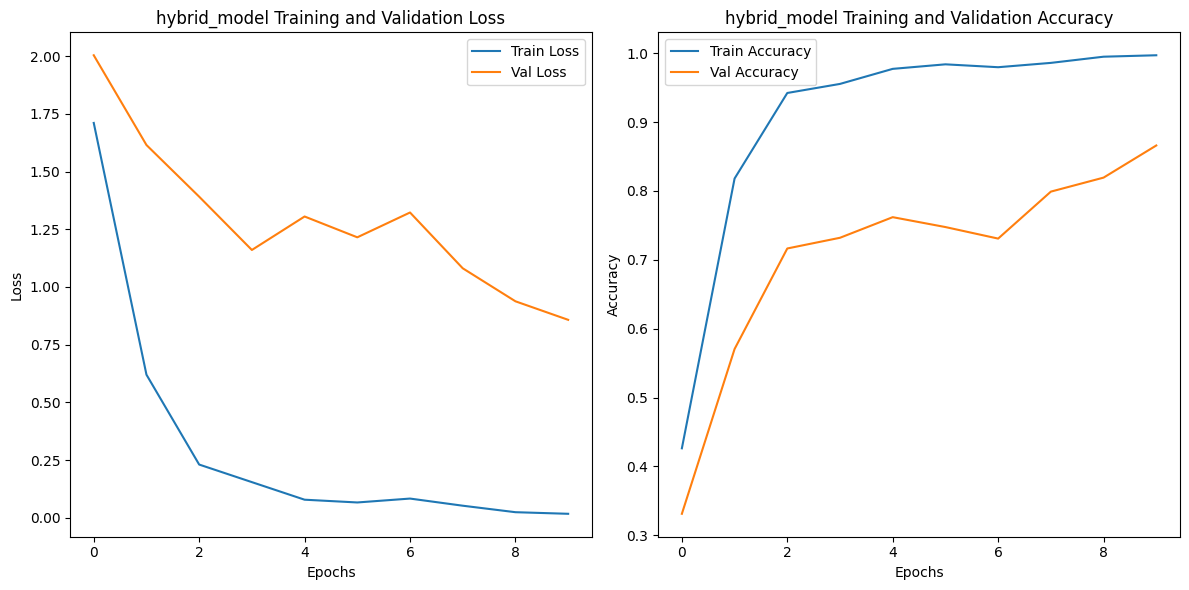

F1 Score (Weighted): 0.5887
Precision (Weighted): 0.7113
Recall (Weighted): 0.6110
Classification Report:
               precision    recall  f1-score   support

       Angry       0.95      0.97      0.96        87
       Cheer       0.91      0.85      0.88        87
        Clap       0.90      0.83      0.86        88
        Come       0.00      0.00      0.00        87
       Crazy       0.35      1.00      0.52        87
    Facepalm       0.27      0.75      0.40        87
        Idle       0.93      0.75      0.83       188
       Point       1.00      0.01      0.02        87
      Salute       0.40      0.20      0.26        87
    ThumbsUp       0.86      0.49      0.63        87
        Wave       1.00      0.71      0.83        87

    accuracy                           0.61      1059
   macro avg       0.69      0.60      0.56      1059
weighted avg       0.71      0.61      0.59      1059

Test Accuracy for subject 003: 0.6110
Running LOSO-CV with subject 004 as the te

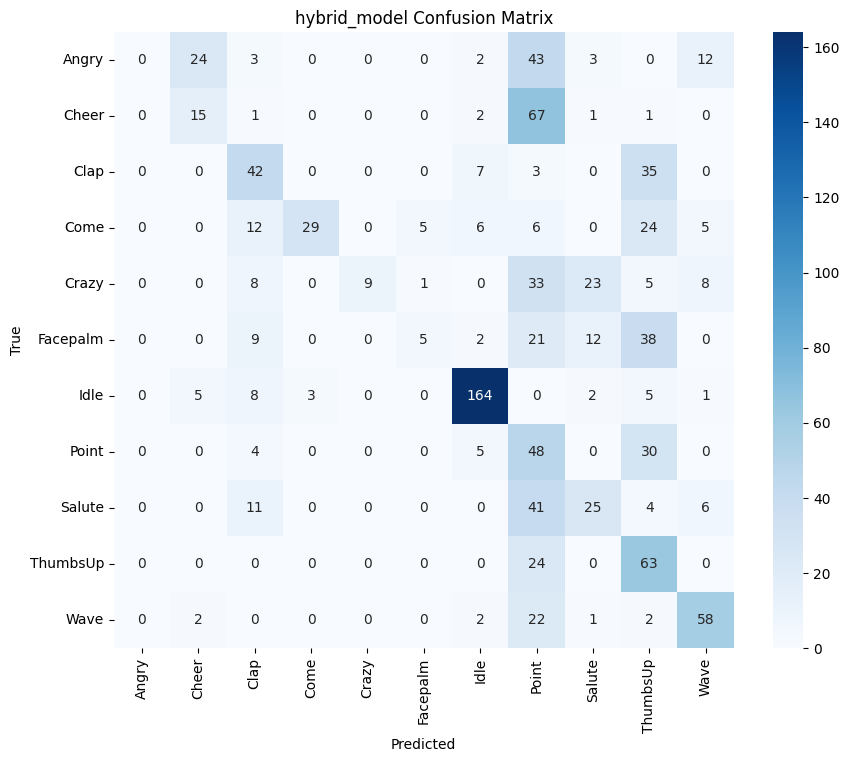

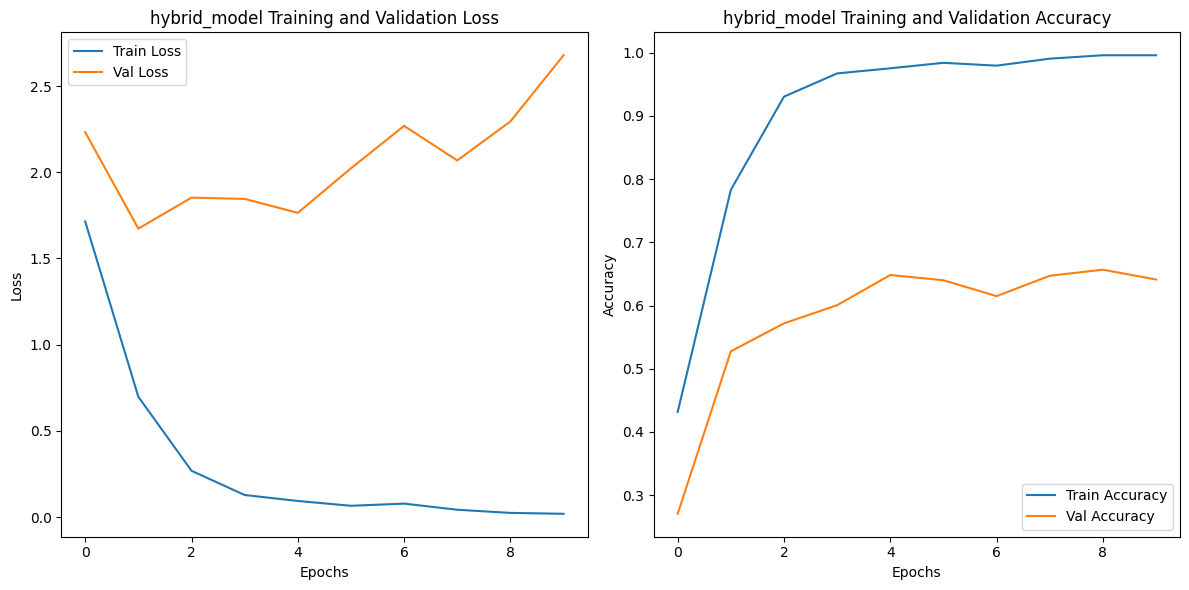

c:\Users\amyco\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amyco\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amyco\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amyco\.conda\env

F1 Score (Weighted): 0.4098
Precision (Weighted): 0.5311
Recall (Weighted): 0.4329
Classification Report:
               precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        87
       Cheer       0.33      0.17      0.23        87
        Clap       0.43      0.48      0.45        87
        Come       0.91      0.33      0.49        87
       Crazy       1.00      0.10      0.19        87
    Facepalm       0.45      0.06      0.10        87
        Idle       0.86      0.87      0.87       188
       Point       0.16      0.55      0.24        87
      Salute       0.37      0.29      0.32        87
    ThumbsUp       0.30      0.72      0.43        87
        Wave       0.64      0.67      0.66        87

    accuracy                           0.43      1058
   macro avg       0.50      0.39      0.36      1058
weighted avg       0.53      0.43      0.41      1058

Test Accuracy for subject 004: 0.4329
Running LOSO-CV with subject 005 as the te

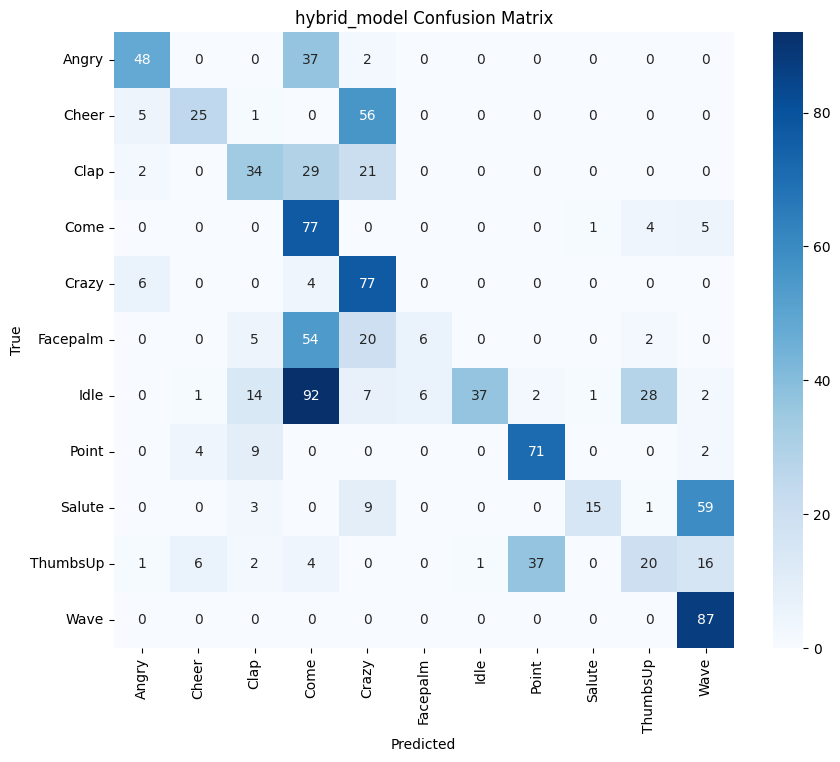

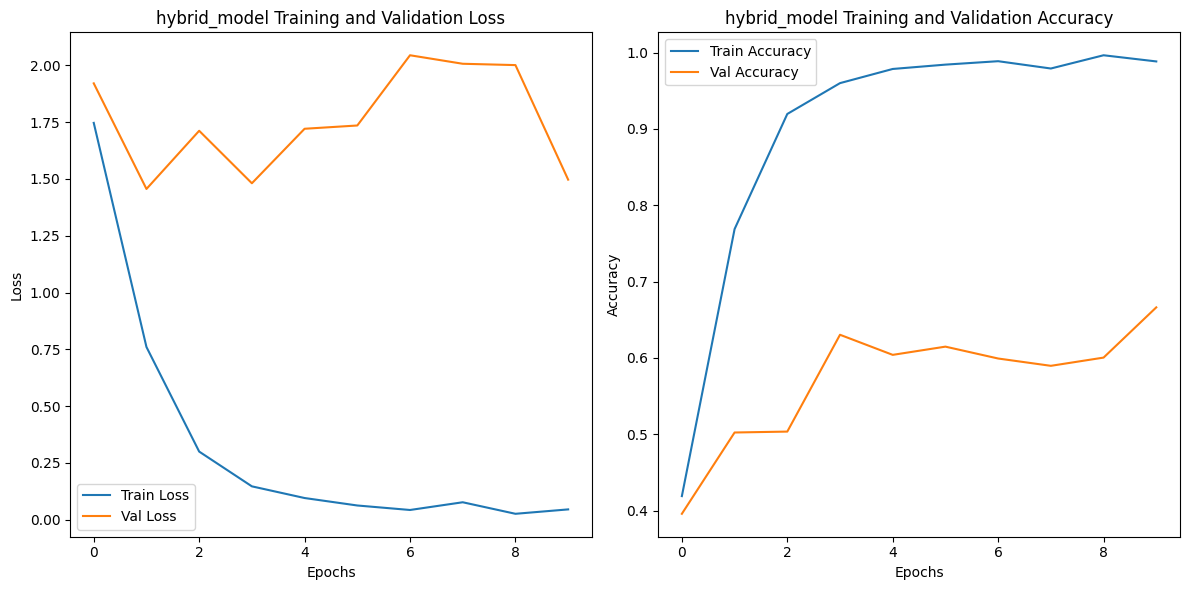

F1 Score (Weighted): 0.4302
Precision (Weighted): 0.6284
Recall (Weighted): 0.4698
Classification Report:
               precision    recall  f1-score   support

       Angry       0.77      0.55      0.64        87
       Cheer       0.69      0.29      0.41        87
        Clap       0.50      0.40      0.44        86
        Come       0.26      0.89      0.40        87
       Crazy       0.40      0.89      0.55        87
    Facepalm       0.50      0.07      0.12        87
        Idle       0.97      0.19      0.32       190
       Point       0.65      0.83      0.72        86
      Salute       0.88      0.17      0.29        87
    ThumbsUp       0.36      0.23      0.28        87
        Wave       0.51      1.00      0.67        87

    accuracy                           0.47      1058
   macro avg       0.59      0.50      0.44      1058
weighted avg       0.63      0.47      0.43      1058

Test Accuracy for subject 005: 0.4698


In [11]:
subject_ids = sorted(data.keys())

for subject_id in subject_ids:
    print(f"Running LOSO-CV with subject {subject_id} as the test set")
    
    X_train, y_train, X_test, y_test, labels = prepare_data_for_LOSO(data, subject_id_to_exclude=subject_id)
    
    test_accuracy = train_and_evaluate_lstm(X_train, y_train, X_test, y_test, hybrid_model, labels, save_dir='lstm_best_model')
    print(f"Test Accuracy for subject {subject_id}: {test_accuracy:.4f}")
